In [ ]:
#17.1. MedBuddy.ML - Heart Disease Risk Prediction

#Dataset: heart.csv

#1. Setup

In [ ]:
# install required libraries - can also be executed in the terminal in .venv
# %pip install -r requirements.txt

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    recall_score,
    f1_score,
)

In [2]:
# configurations
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.3f}")
sns.set_theme(style="darkgrid")

RANDOM_STATE = 42
CSV_PATH="/home/sid/ml-17-med-buddy-ml/dataset/heart.csv"
TARGET_COL="target"

In [3]:
df = pd.read_csv(CSV_PATH)
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.000,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.100,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.600,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.000,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.900,1,3,2,0


In [4]:
# basic dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [5]:
numerical_features = [
    "age",
    "trestbps",
    "chol",
    "thalach",
    "oldpeak",
    "ca"
]

categorical_features = [
    "sex",
    "cp",
    "fbs",
    "restecg",
    "exang",
    "slope",
    "thal",
    "target"
]

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'target']


In [6]:
# missing values
df.isna().sum().sort_values()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
# quick checks for encoded missing values
for col in df.columns:
    print(df[col].value_counts().head(10))

age
58    68
57    57
54    53
59    46
52    43
56    39
51    39
62    37
60    37
44    36
Name: count, dtype: int64
sex
1    713
0    312
Name: count, dtype: int64
cp
0    497
2    284
1    167
3     77
Name: count, dtype: int64
trestbps
120    128
130    123
140    107
110     64
150     55
138     45
128     39
125     38
160     36
112     30
Name: count, dtype: int64
chol
204    21
234    21
197    19
212    18
254    17
269    16
240    14
177    14
282    14
211    13
Name: count, dtype: int64
fbs
0    872
1    153
Name: count, dtype: int64
restecg
1    513
0    497
2     15
Name: count, dtype: int64
thalach
162    35
160    31
163    29
173    28
152    28
144    26
132    26
125    25
150    25
143    23
Name: count, dtype: int64
exang
0    680
1    345
Name: count, dtype: int64
oldpeak
0.000    329
1.200     58
1.000     51
0.600     47
0.800     44
1.400     44
1.600     37
0.200     37
1.800     36
2.000     32
Name: count, dtype: int64
slope
1    482
2    469
0     74
N

In [ ]:
#NOTE: No missing values or encoded missing values

In [10]:
# duplicates
duplicate_mask = df.duplicated()
num_duplicates = duplicate_mask.sum()
print("Number of duplicate rows:", num_duplicates)

# (optional) drop duplicates if present
# df = df.drop_duplicates()
# print("Shape after dropping duplicates:", df.shape)

Number of duplicate rows: 723


In [ ]:
#Although the dataset contains a large number of duplicate rows, these likely represent multiple real-world patients with identical clinical measurements. Dropping these rows would drastically reduce the dataset size and distort the natural frequency of observations in the data.

#We therefore retain duplicate rows, but take special care during validation. To ensure a fair evaluation, we use group-based splitting (Group K-Fold) so that identical data points are never shared between training and validation folds.

#While tree-based models are robust to duplicate observations during training, preventing duplicate leakage across folds is essential to obtain reliable and unbiased performance estimates.

In [11]:
# target distribution
print(df[TARGET_COL].value_counts())
print("-"*50)
print(df[TARGET_COL].value_counts(normalize=True) * 100)

target
1    526
0    499
Name: count, dtype: int64
--------------------------------------------------
target
1   51.317
0   48.683
Name: proportion, dtype: float64


In [12]:
df[numerical_features].describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,1025.000,1025.000,1025.000,1025.000,1025.000,1025.000
mean,54.434,131.612,246.000,149.114,1.072,0.754
std,9.072,17.517,51.593,23.006,1.175,1.031
min,29.000,94.000,126.000,71.000,0.000,0.000
25%,48.000,120.000,211.000,132.000,0.000,0.000
50%,56.000,130.000,240.000,152.000,0.800,0.000
75%,61.000,140.000,275.000,166.000,1.800,1.000
max,77.000,200.000,564.000,202.000,6.200,4.000


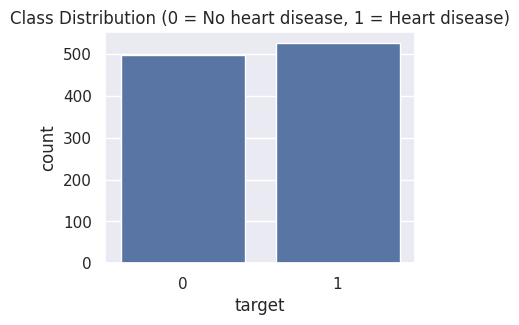

In [13]:
# visualize target distribution
plt.figure(figsize=(4, 3))
sns.countplot(x=TARGET_COL, data=df)
plt.title("Class Distribution (0 = No heart disease, 1 = Heart disease)")
plt.show()


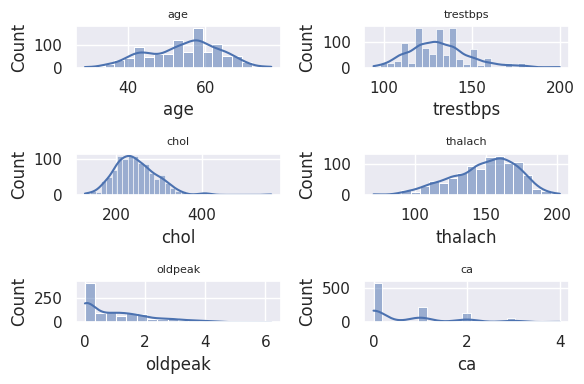

In [14]:
# histogram plot - distribution - for numerical features
fig, axes = plt.subplots(3, 2, figsize=(6, 4))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col, fontsize=8)

plt.tight_layout()
plt.show()

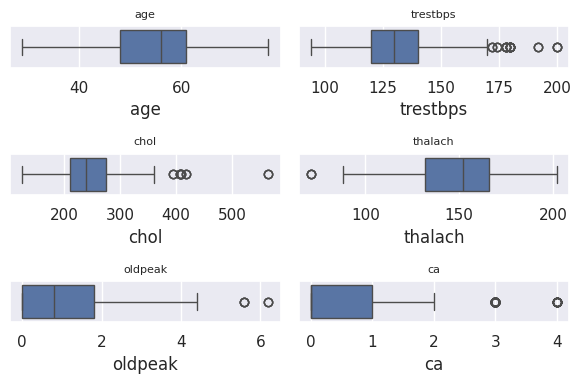

In [15]:
# outliers analysis - boxplot
fig, axes = plt.subplots(3, 2, figsize=(6, 4))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(col, fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
#Not much outliers. We can leave it as is

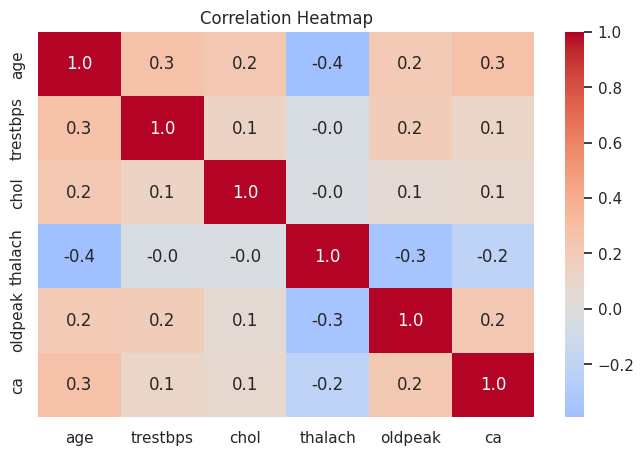

In [16]:
# identify presence of highly correlated columns & feature relationships
plt.figure(figsize=(8, 5))
sns.heatmap(
    df[numerical_features].corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".1f",
    center=0
)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
#**No highly correlated columns**

In [ ]:
#Data Preprocessing

In [17]:
# Separate X and y
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Create a signature for each feature row - to prevent duplicates flow to test set
row_signature = pd.util.hash_pandas_object(X, index=False)

In [18]:
# Split data into train and test sets using GroupShuffleSplit
gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.15,
    random_state=RANDOM_STATE
)

train_idx, test_idx = next(
    gss.split(X, y, groups=row_signature)
)

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (869, 13)
Test shape: (156, 13)


In [19]:
print("Dataset size", X.shape)
print("Train Dataset size", X_train.shape)
print("Test Dataset size", X_test.shape)

Dataset size (1025, 13)
Train Dataset size (869, 13)
Test Dataset size (156, 13)


In [ ]:
#Baseline Model - Logistic Regression

In [20]:
base_pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression())
    ]
)

In [21]:
# training the base pipeline
base_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])

In [22]:
# reusable evaluation function
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name):
    # predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # accuracy
    train_acc = accuracy_score(y_train, y_train_pred) * 100
    test_acc = accuracy_score(y_test, y_test_pred) * 100

    # results
    print(f"{model_name} - Train Accuracy: {train_acc:.2f}%")
    print(f"{model_name} - Test Accuracy: {test_acc:.2f}%\n")

    print("-"*40)

    print("Train Classification Report")
    print(classification_report(y_train, y_train_pred))

    print("-"*40)

    print("Test Classification Report")
    print(classification_report(y_test, y_test_pred))

In [23]:
evaluate_classifier(
    base_pipe,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Logistic Regression - Base Model"
)

Logistic Regression - Base Model - Train Accuracy: 84.23%
Logistic Regression - Base Model - Test Accuracy: 83.33%

----------------------------------------
Train Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       430
           1       0.81      0.89      0.85       439

    accuracy                           0.84       869
   macro avg       0.85      0.84      0.84       869
weighted avg       0.85      0.84      0.84       869

----------------------------------------
Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.71      0.79        69
           1       0.80      0.93      0.86        87

    accuracy                           0.83       156
   macro avg       0.85      0.82      0.83       156
weighted avg       0.84      0.83      0.83       156



In [ ]:
#Descent Performance. Can be improved.

In [ ]:
# Model Selection

In [24]:
# models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=RANDOM_STATE),
    "Support Vector Machine": SVC(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier()
}

In [25]:
groups = pd.util.hash_pandas_object(X_train, index=False)

k = 5
cv = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

In [26]:
for name, model in models.items():

    recall_scores = []
    f1_scores = []

    for tr_idx, te_idx in cv.split(X_train, y_train, groups=groups):
        X_tr, X_te = X_train.iloc[tr_idx], X_train.iloc[te_idx]
        y_tr, y_te = y_train.iloc[tr_idx], y_train.iloc[te_idx]

        pipeline = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("model", model)
            ]
        )

        pipeline.fit(X_tr, y_tr)
        pred = pipeline.predict(X_te)

        recall_scores.append(round(recall_score(y_te, pred), 2))
        f1_scores.append(round(f1_score(y_te, pred), 2))

    print("Model name:", name)
    print("Recall values:", recall_scores)
    print("F1 scores:", f1_scores)
    print("\nCV Recall mean:", round(float(np.mean(recall_scores)), 4))
    print("CV F1 Score mean:", round(float(np.mean(f1_scores)), 4))
    print("-"*50)

# cross validation is a more reliable validation technique than a simple train-test split

Model name: Logistic Regression
Recall values: [0.95, 0.74, 0.83, 0.87, 0.86]
F1 scores: [0.72, 0.8, 0.86, 0.83, 0.84]

CV Recall mean: 0.85
CV F1 Score mean: 0.81
--------------------------------------------------
Model name: Support Vector Machine
Recall values: [0.9, 0.73, 0.71, 0.85, 0.97]
F1 scores: [0.7, 0.81, 0.76, 0.83, 0.9]

CV Recall mean: 0.832
CV F1 Score mean: 0.8
--------------------------------------------------
Model name: Random Forest
Recall values: [0.95, 0.69, 0.83, 0.8, 0.94]
F1 scores: [0.75, 0.77, 0.86, 0.77, 0.87]

CV Recall mean: 0.842
CV F1 Score mean: 0.804
--------------------------------------------------
Model name: XGBoost
Recall values: [0.94, 0.67, 0.72, 0.89, 0.94]
F1 scores: [0.73, 0.75, 0.82, 0.83, 0.87]

CV Recall mean: 0.832
CV F1 Score mean: 0.8
--------------------------------------------------


In [ ]:
#RandomForestClassifier provides the highest performance

In [ ]:
#Hyperparameter Tuning - RFC

In [27]:
rfc_pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
        ))
    ]
)

In [28]:
# parameter distributions
param_dist = {
    "model__n_estimators": randint(400, 1200),
    "model__max_depth": [3, 4, 5, 6],
    "model__min_samples_split": randint(10, 40),
    "model__min_samples_leaf": randint(4, 20),
    "model__max_features": [0.25, 0.35, 0.5, "sqrt"],
    "model__bootstrap": [True],
    "model__max_samples": uniform(0.6, 0.35),
    "model__ccp_alpha": uniform(0.0, 0.02),
}

In [29]:
# randomized search
random_search = RandomizedSearchCV(
    estimator=rfc_pipe,
    param_distributions=param_dist,
    n_iter=60,
    scoring="f1_macro",
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=2,
    n_jobs=-1
)

In [30]:
# performing gridsearchcv
random_search.fit(X_train, y_train, groups=groups)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END model__bootstrap=True, model__ccp_alpha=0.013017769458977058, model__max_depth=3, model__max_features=0.35, model__max_samples=0.8526995702933886, model__min_samples_leaf=17, model__min_samples_split=15, model__n_estimators=785; total time=   1.6s
[CV] END model__bootstrap=True, model__ccp_alpha=0.013017769458977058, model__max_depth=3, model__max_features=0.35, model__max_samples=0.8526995702933886, model__min_samples_leaf=17, model__min_samples_split=15, model__n_estimators=785; total time=   1.7s
[CV] END model__bootstrap=True, model__ccp_alpha=0.00749080237694725, model__max_depth=3, model__max_features=0.5, model__max_samples=0.8561978796339917, model__min_samples_leaf=16, model__min_samples_split=30, model__n_estimators=1014; total time=   2.1s
[CV] END model__bootstrap=True, model__ccp_alpha=0.00749080237694725, model__max_depth=3, model__max_features=0.5, model__max_samples=0.8561978796339917, model__min_sam

RandomizedSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True],
                                        'model__ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0...
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ce4a2641b70>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ce4a26853f0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ce4a2642a70>},
                   random_state=42, scoring='f1_macro', verbose=2)

In [31]:
print("Hyperparameter Tuning result:")
print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Hyperparameter Tuning result:
Best params: {'model__bootstrap': True, 'model__ccp_alpha': 0.00026529922319733055, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__max_samples': 0.7971508762459387, 'model__min_samples_leaf': 13, 'model__min_samples_split': 18, 'model__n_estimators': 745}
Best score: 0.8447088151801054


In [ ]:
#Retrain with best params

In [32]:
rfc_best = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            n_estimators=random_search.best_params_["model__n_estimators"],
            max_depth=random_search.best_params_["model__max_depth"],
            min_samples_split=random_search.best_params_["model__min_samples_split"],
            min_samples_leaf=random_search.best_params_["model__min_samples_leaf"],
            max_features=random_search.best_params_["model__max_features"],
            bootstrap=random_search.best_params_["model__bootstrap"],
        ))
    ]
)

In [ ]:
# train the best model
rfc_best.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=13,
                                        min_samples_split=18, n_estimators=745,
                                        n_jobs=-1, random_state=42))])

Model Evaluation

In [34]:
evaluate_classifier(
    rfc_best,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="Random Forest - Best Model"
)

Random Forest - Best Model - Train Accuracy: 88.61%
Random Forest - Best Model - Test Accuracy: 81.41%

----------------------------------------
Train Classification Report
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       430
           1       0.85      0.94      0.89       439

    accuracy                           0.89       869
   macro avg       0.89      0.89      0.89       869
weighted avg       0.89      0.89      0.89       869

----------------------------------------
Test Classification Report
              precision    recall  f1-score   support

           0       0.84      0.71      0.77        69
           1       0.80      0.90      0.84        87

    accuracy                           0.81       156
   macro avg       0.82      0.80      0.81       156
weighted avg       0.82      0.81      0.81       156



In [35]:
import pandas as pd

def predict_heart_disease(input_features):

    # create DataFrame with correct column order
    input_df = pd.DataFrame(
        [input_features],
        columns=X_train.columns
    )

    # class prediction
    prediction = rfc_best.predict(input_df)[0]

    # probability prediction (positive class)
    probability = rfc_best.predict_proba(input_df)[0][1]

    # output
    print(f"Predicted class: {prediction}")
    print(f"Heart disease risk probability: {probability:.2%}")

    if prediction == 1:
        print("Diagnosis: High risk of heart disease 🔴")
    else:
        print("Diagnosis: Low risk of heart disease 🟢")

    return prediction, probability

In [36]:
y_test[y_test==1].head()

24    1
38    1
57    1
68    1
84    1
Name: target, dtype: int64

In [37]:
y_test[y_test==0].head()

4     0
8     0
17    0
43    0
53    0
Name: target, dtype: int64

In [38]:
# sample unknown data point - access from test data index
test_1 = X_test.loc[24].tolist()
print(test_1)

[42.0, 0.0, 2.0, 120.0, 209.0, 0.0, 1.0, 173.0, 0.0, 0.0, 1.0, 0.0, 2.0]


In [39]:
predict_heart_disease(test_1)

Predicted class: 1
Heart disease risk probability: 88.02%
Diagnosis: High risk of heart disease 🔴


(1, 0.8802023759858578)

In [40]:
# sample unknown data point - access from test data index
test_2 = X_test.loc[4].tolist()
print(test_2)

[62.0, 0.0, 0.0, 138.0, 294.0, 1.0, 1.0, 106.0, 0.0, 1.9, 1.0, 3.0, 2.0]


In [41]:
predict_heart_disease(test_2)

Predicted class: 0
Heart disease risk probability: 28.49%
Diagnosis: Low risk of heart disease 🟢


(0, 0.28488909654952704)